# Overall workflow
![alt text](https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/workflow.png?raw=true)

# Load necessary Python packages

In [149]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                              AutoMinorLocator)
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk
import time
import pylab as pl
from IPython import display
from tqdm.auto import tqdm
%matplotlib inline 

# Read SMILES and features into Pandas dataframes

In [150]:
features = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/features.csv?raw=true"
smiles = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/SMILES.csv?raw=true"

# Load SMILES and features
dfSMILES = pd.read_csv(smiles)
Xsmiles = dfSMILES.SMILES
print(Xsmiles)
X = pd.read_csv(features)
print(X.shape)

0                         N#CC(c1ccccc1)C(Br)Oc1ccccc1
1      O=[N+]([O-])c1ccc(C(c2ccccc2)C(Br)Oc2ccccc2)cc1
2                     CC(Oc1ccccc1)C(C#N)c1ccc(C#N)cc1
3                   COC(C#N)C(C)(C)c1ccc(-c2ccccc2)cc1
4        COC(Oc1ccccc1)C(C)(C#N)c1ccc([N+](=O)[O-])cc1
                            ...                       
995                       COCOC(OC)C(c1ccccc1)c1ccccc1
996              COCOC(OC)C(C#N)(c1ccccc1)c1ccc(OC)cc1
997                         COCOCC(C)c1ccc(C(=O)OC)cc1
998                     COCOC(Br)C(C)(C#N)c1ccc(OC)cc1
999        COCOCC(C#N)(c1ccccc1)c1ccc([N+](=O)[O-])cc1
Name: SMILES, Length: 1000, dtype: object
(1000, 125)


## To draw 2D molecular structure from SMILES and vice versa: https://pubchem.ncbi.nlm.nih.gov//edit3/index.html

# Perform principle component analysis 

No. of PC           Cumulative explained variance                                                   
--------------------------------------------------
1                   0.881947                                                                        
2                   0.976453                                                                        
3                   0.997720                                                                        
4                   0.999351                                                                        
5                   0.999596                                                                        
6                   0.999714                                                                        
7                   0.999817                                                                        
8                   0.999886                                                                        
9                   0.999932            

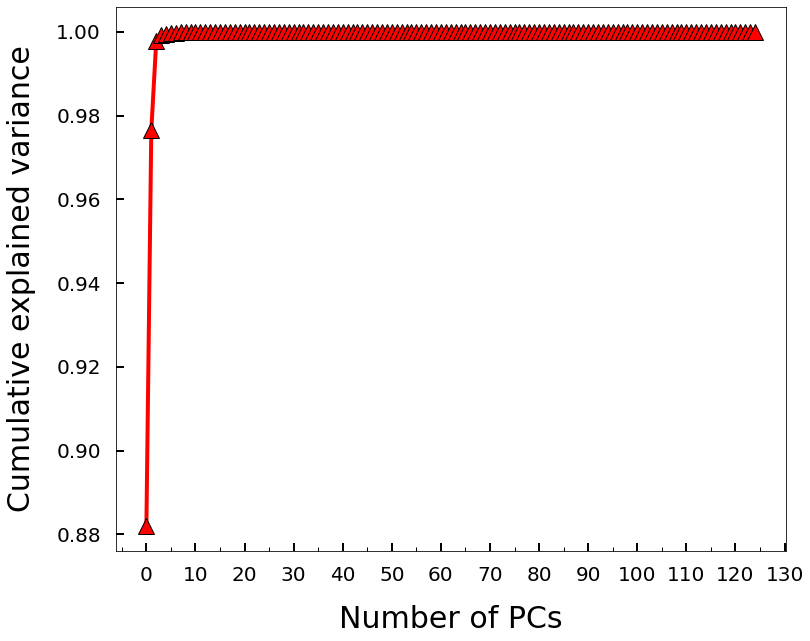

In [151]:
pca = PCA().fit(X)

#Plotting

fig, ax1 = plt.subplots()

#plt.rc('font', family='serif')

ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
#ax1.set_ylim([0.8,1.05])
#ax1.set_xlim([-1,28])
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, 
         markeredgecolor='black', linestyle='-',linewidth=4, color='red')

print('{:<20s}{:<80s}'.format('No. of PC','Cumulative explained variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

In [152]:
n_PC = 15  # Number of PCs used
st = StandardScaler()
Xdata = st.fit_transform(X)

pca = PCA(n_components=n_PC)
Xdata = pca.fit_transform(Xdata)

# Define Gaussian Process Regression model and acquisition functions

In [153]:
def gpregression(Xtrain,Ytrain,Nfeature):    
    cmean=[1.0]*Nfeature
    cbound=[[1e-3, 1e3]]*Nfeature
    kernel = C(1.0, (1e-3,1e3)) * matk(cmean,cbound,1.5) + Wht(1.0, (1e-3, 1e3))  # Matern kernel
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40, normalize_y=False)
    gp.fit(Xtrain, Ytrain)
    return gp

# Predict result using GP regression model
def gprediction(gpnetwork,xtest):
    y_pred, sigma = gpnetwork.predict(xtest, return_std=True)
    return y_pred, sigma

# https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/util.py

# Compute expected improvement
def expectedImprovement(xdata,gpnetwork,ybest,epsilon):
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    expI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest)/float(esigma[ii])
            expI[ii]=(ye_pred[ii]-ybest-epsilon)*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
        else:
            expI[ii]=0.0
    return expI

def probabilityOfImprovement(xdata,gpnetwork,ybest,epsilon):
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    poI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest-epsilon)/float(esigma[ii])
            poI[ii]=norm.cdf(zzval)
        else:
            poI[ii]=0.0
    return poI

def upperConfidenceBound(xdata,gpnetwork,ybest,epsilon):
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    ucb = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            ucb[ii]=(ye_pred[ii]+epsilon*esigma[ii])
        else:
            ucb[ii]=0.0
    return ucb

# Select 10 initial random molecules for property (E$^{ox}$) evaluation

In [154]:
ndata = X.shape[0]   # Length of all data or number of molecules in the dataset
ntrainInit = 10 # Number of initial training data points
nremain = ndata - ntrainInit
np.random.seed(10) # Fix the seed value
dataset = np.random.permutation(ndata)
a1data = np.empty(ntrainInit, dtype=int)
a2data = np.empty(nremain, dtype=int)
a1data[:] = dataset[0:ntrainInit]
a2data[:] = dataset[ntrainInit:ndata]

Xtrain = np.ndarray(shape=(ntrainInit, n_PC), dtype=float)
XtrainSmiles = np.chararray(ntrainInit, itemsize=100)
Ytrain = np.zeros(ntrainInit, dtype=float)
Xtrain[0:ntrainInit, :] = Xdata[a1data, :]
XtrainSmiles[0:ntrainInit] = Xsmiles[a1data]

Xremain = np.ndarray(shape=(nremain, n_PC), dtype=float)
XremainSmiles = np.chararray(nremain, itemsize=100)
Yremain = np.empty(nremain, dtype=float)
Xremain[0:nremain, :] = Xdata[a2data, :]
XremainSmiles[0:nremain] = Xsmiles[a2data]
#Yremain[0:nremain] = Ydata[a2data]

print('*** Initial training set ***')
print(115*'-')
print('{:<5s}{:<80s}{:<15s}'.format('ID','SMILES','Eox (V vs. NHE)'))
print(115*'-')
for i in range(ntrainInit):
    print('{:<5d}{:<80s}{:<15f}'.format(i,XtrainSmiles[i].decode(),Ytrain[i]))
print(115*'-')  
print("Total number of inital training points: ", ntrainInit)

*** Initial training set ***
-------------------------------------------------------------------------------------------------------------------
ID   SMILES                                                                          Eox (V vs. NHE)
-------------------------------------------------------------------------------------------------------------------
0    CCc1ccc(C(C)(c2ccccc2)C(C)OCOC)cc1                                              0.000000       
1    COC(C#N)C(C#N)c1ccccc1                                                          0.000000       
2    COCC(c1ccccc1)c1ccc([N+](=O)[O-])cc1                                            0.000000       
3    N#CC(C#N)(c1ccc([N+](=O)[O-])cc1)C(Br)Oc1ccccc1                                 0.000000       
4    COC(=O)c1ccc(C(c2ccccc2)(c2ccccc2)C(OC)c2ccccc2)cc1                             0.000000       
5    CCc1ccc(C(c2ccccc2)(c2ccccc2)C(OC)OC)cc1                                        0.000000       
6    CCc1ccc(C(c2ccccc2)C(C#N)OC

In [155]:
computedEox = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/computedEox.csv?raw=true"
dfEox = pd.read_csv(computedEox) # Load computed Eox 

def lookupComputedEox(smiles):  # Look up function for computed Eox values
    smilesLoc = dfSMILES[dfSMILES.SMILES == smiles].index[0]
    return dfEox.iloc[smilesLoc].values[0]

# Evaluate E$^{ox}$ of the intial training set

In [156]:
for i,sml in enumerate(XtrainSmiles.decode()):
    Ytrain[i] = lookupComputedEox(sml)

#Ytrain[0:ntrain] = Ydata[a1data]   # Add computed values into Ytrain
#Yremain[0:nremain] = Ydata[a2data]

yoptLoc = np.argmax(Ytrain)
yopttval = Ytrain[yoptLoc]
xoptSmiles = XtrainSmiles[yoptLoc].decode()
yoptstep=0
yopinit = yopttval
ntrain = ntrainInit
print('*** Initial training set ***')
print(115*'-')
print('{:<5s}{:<80s}{:<15s}'.format('ID','SMILES','Eox (V vs. NHE)'))
print(115*'-')
for i in range(ntrain):
    print('{:<5d}{:<80s}{:<15f}'.format(i,XtrainSmiles[i].decode(),Ytrain[i]))
print(115*'-')  
print("Total number of inital training points: ", ntrainInit)
print("Initial best SMILES is "+xoptSmiles+' with computed Eox = '+str(yopttval)+' V')

*** Initial training set ***
-------------------------------------------------------------------------------------------------------------------
ID   SMILES                                                                          Eox (V vs. NHE)
-------------------------------------------------------------------------------------------------------------------
0    CCc1ccc(C(C)(c2ccccc2)C(C)OCOC)cc1                                              1.818360       
1    COC(C#N)C(C#N)c1ccccc1                                                          2.758792       
2    COCC(c1ccccc1)c1ccc([N+](=O)[O-])cc1                                            2.339703       
3    N#CC(C#N)(c1ccc([N+](=O)[O-])cc1)C(Br)Oc1ccccc1                                 2.372655       
4    COC(=O)c1ccc(C(c2ccccc2)(c2ccccc2)C(OC)c2ccccc2)cc1                             2.083358       
5    CCc1ccc(C(c2ccccc2)(c2ccccc2)C(OC)OC)cc1                                        1.845325       
6    CCc1ccc(C(c2ccccc2)C(C#N)OC

# Build the Bayesian optimization cycles

## Step 1: Train GPR model and make predictions 

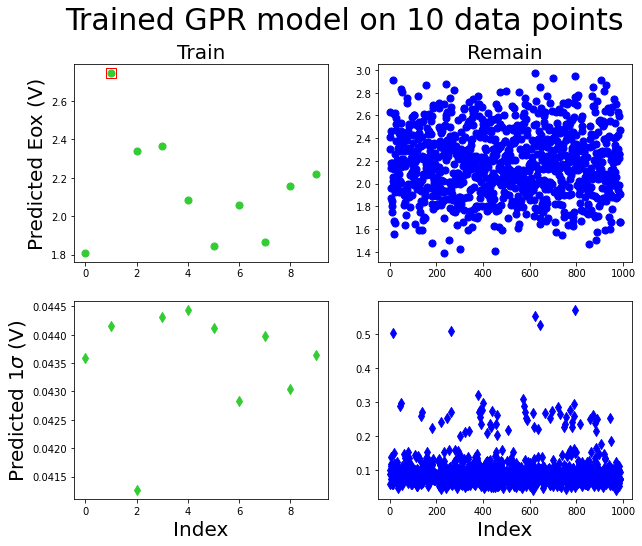

In [157]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)
titleSize=30
axisTitleSize=20
markerSize=50

fig.suptitle('Trained GPR model on '+str(ntrain)+' data points',fontsize=titleSize)
#axs[0].plot(x, y)
#axs[1].plot(x, -y)

gpnetwork = gpregression(Xtrain, Ytrain, n_PC)

yt_pred, tsigma = gprediction(gpnetwork, Xtrain)
ybestloc = np.argmax(Ytrain) # The current best y value
ybest_pred = yt_pred[ybestloc]
axs[0,0].scatter(np.arange(len(yt_pred)),yt_pred,color='limegreen',s=markerSize)
axs[0, 0].set_title('Train', fontsize=axisTitleSize)
axs[1,0].scatter(np.arange(len(tsigma)),tsigma,color='limegreen',marker='d',s=markerSize)
axs[0,0].scatter(ybestloc,ybest_pred,color='r',marker='s',s=markerSize+50,facecolor='None')

yr_pred, rsigma = gprediction(gpnetwork, Xremain)
axs[0,1].scatter(np.arange(len(yr_pred)),yr_pred,color='b',s=markerSize)
axs[0, 1].set_title('Remain',fontsize=axisTitleSize)
axs[1,1].scatter(np.arange(len(rsigma)),rsigma,color='b',marker='d',s=markerSize)

axs[0,0].set_ylabel('Predicted Eox (V)',fontsize=axisTitleSize)
axs[1,0].set_xlabel('Index',fontsize=axisTitleSize)
axs[1,0].set_ylabel('Predicted 1$\sigma$ (V)',fontsize=axisTitleSize)
axs[1,1].set_xlabel('Index',fontsize=axisTitleSize)

#rmse = np.sqrt(np.mean((yt_-targets)**2))
#print('Current GPR error: RMSE= ', rmse)

plt.show()

## Step 2: Evaluate the Acquisition Function and suggest next data point/molecule for evaluation

Computing EI on the remaining 990 data points


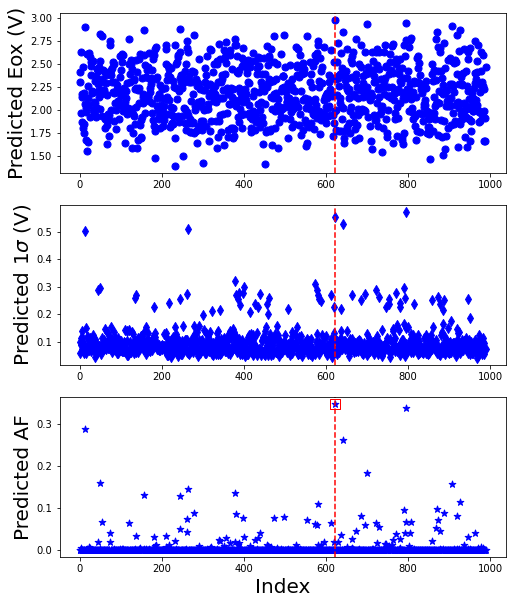

Based on the evalulate AF, the next SMILES to be evaluated is COCOCCc1ccccc1


In [158]:
fig, axs = plt.subplots(3)
fig.set_size_inches(8,10)

print('Computing EI on the remaining '+str(ndata-ntrain)+' data points')
epsilon = 0.01 # Control exploration/exploitation
expI = expectedImprovement(Xremain, gpnetwork, ybest_pred, epsilon)
AFmax = np.max(expI)
AFmaxloc = np.argmax(expI)
XSmilesNew = XremainSmiles[AFmaxloc].decode()

axs[0].scatter(np.arange(len(yr_pred)),yr_pred,color='b',s=markerSize)
axs[0].axvline(AFmaxloc,color='r',ls='--')
axs[0].set_ylabel('Predicted Eox (V)',fontsize=axisTitleSize)

axs[1].scatter(np.arange(len(rsigma)),rsigma,color='b',marker='d',s=markerSize)
axs[1].axvline(AFmaxloc,color='r',ls='--')
axs[1].set_ylabel('Predicted 1$\sigma$ (V)',fontsize=axisTitleSize)


axs[2].scatter(np.arange(len(expI)),expI,color='b',marker='*',s=markerSize)
axs[2].scatter(AFmaxloc,AFmax,edgecolor='r',marker='s',s=markerSize+50,facecolor='None')
axs[2].axvline(AFmaxloc,color='r',ls='--')
axs[2].set_xlabel('Index',fontsize=axisTitleSize)
axs[2].set_ylabel('Predicted AF',fontsize=axisTitleSize)

plt.show()
print('Based on the evalulate AF, the next SMILES to be evaluated is '+XSmilesNew)

## Step 3: Evaluate the next data point and add to the training set

In [159]:
YEoxNew = lookupComputedEox(XremainSmiles[AFmaxloc].decode())
ybestloc = np.argmax(Ytrain) # The current best y value
ytrue = Ytrain[ybestloc]

if yopttval < YEoxNew:  # Identify current SMILES with maximum computed Eox
    yopttval = YEoxNew
    xoptSmiles = XtrainSmiles[ybestloc]

if XSmilesNew in XtrainSmiles:
    print("New SMILES is already in train set")  
else:
    print('Added '+XSmilesNew+' with Eox='+str(YEoxNew)+' V to the training set')
    xtnewSmiles = np.append(XtrainSmiles, XSmilesNew)
    ytnew = np.append(Ytrain, YEoxNew)
    xtnew = np.append(Xtrain, Xremain[AFmaxloc]).reshape(-1, n_PC)

    xrnew = np.delete(Xremain, AFmaxloc, 0)
    xrnewSmiles = np.delete(XremainSmiles, AFmaxloc)

    Xtrain = xtnew
    XtrainSmiles = xtnewSmiles
    Ytrain = ytnew

    Xremain = xrnew
    XremainSmiles = xrnewSmiles
    #Yremain = yrnew
    del xtnew, xtnewSmiles, ytnew, xrnew, xrnewSmiles

ntrain = len(XtrainSmiles)
print('*** Current training set ***')
print(115*'-')
print('{:<5s}{:<80s}{:<15s}'.format('ID','SMILES','Eox (V vs. NHE)'))
print(115*'-')
for i in range(ntrain):
    print('{:<5d}{:<80s}{:<15f}'.format(i,XtrainSmiles[i],Ytrain[i]))
print(115*'-')  
print('Total number of training points: ', ntrain)
print('Current best SMILES (id= '+str(np.argmax(Ytrain))+'), is '+xoptSmiles+' with computed Eox = '+str(yopttval)+' V')
print('***Go back to step 1 to repeat the BO loop***')

Added COCOCCc1ccccc1 with Eox=2.25605968 V to the training set
*** Current training set ***
-------------------------------------------------------------------------------------------------------------------
ID   SMILES                                                                          Eox (V vs. NHE)
-------------------------------------------------------------------------------------------------------------------
0    CCc1ccc(C(C)(c2ccccc2)C(C)OCOC)cc1                                              1.818360       
1    COC(C#N)C(C#N)c1ccccc1                                                          2.758792       
2    COCC(c1ccccc1)c1ccc([N+](=O)[O-])cc1                                            2.339703       
3    N#CC(C#N)(c1ccc([N+](=O)[O-])cc1)C(Br)Oc1ccccc1                                 2.372655       
4    COC(=O)c1ccc(C(c2ccccc2)(c2ccccc2)C(OC)c2ccccc2)cc1                             2.083358       
5    CCc1ccc(C(c2ccccc2)(c2ccccc2)C(OC)OC)cc1                         

# Combine initilization with Bayesian optimization loop

In [160]:
markerSize = 100
axisLabelSize = 35
tickLabelSize = 30
def BayesOpt(Xdata,Ydata,Xinfo,ndata,nPC,eps,af):
    #epsilon = 0.01 # Control exploration/exploitation balance
    ntrain = 10 # Number of initial training data points
    nremain = ndata - ntrain
    dataset = np.random.permutation(ndata)
    a1data = np.empty(ntrain, dtype=int)
    a2data = np.empty(nremain, dtype=int)
    a1data[:] = dataset[0:ntrain]
    a2data[:] = dataset[ntrain:ndata]

    Xtrain = np.ndarray(shape=(ntrain, nPC), dtype=float)
    Xtraininfo = np.chararray(ntrain, itemsize=100)
    Ytrain = np.empty(ntrain, dtype=float)
    Xtrain[0:ntrain, :] = Xdata[a1data, :]
    Xtraininfo[0:ntrain] = Xinfo[a1data]
    Ytrain[0:ntrain] = Ydata[a1data]
    
    yoptLoc = np.argmax(Ytrain)
    yopttval = Ytrain[yoptLoc]
    xoptval = Xtraininfo[yoptLoc]
    yoptstep=0
    yopinit = yopttval
    xoptint = xoptval

    Xremain = np.ndarray(shape=(nremain, nPC), dtype=float)
    Xremaininfo = np.chararray(nremain, itemsize=100)
    Yremain = np.empty(nremain, dtype=float)
    Xremain[0:nremain, :] = Xdata[a2data, :]
    Xremaininfo[0:nremain] = Xinfo[a2data]
    Yremain[0:nremain] = Ydata[a2data]
    
    print('*** Initial training set ***')
    print(115*'-')
    print('{:<5s}{:<80s}{:<15s}'.format('Id','SMILES','Eox'))
    print(115*'-')
    for i in range(ntrain):
        print('{:<5d}{:<80s}{:<15f}'.format(i,Xtraininfo[i].decode(),Ytrain[i]))
    print(115*'-')  

    print("Total number of inital training points: ", ntrain)
    print("Initial best SMILES is "+xoptval.decode()+' with Eox = '+str(yopttval))
    

    for ii in tqdm(range(0, Niteration),desc='Progress'):
        #print('------------')
        #print('Iteration '+str(ii+1))
        #print('Training GPR model on '+str(ntrain+ii)+' data points')
        gpnetwork = gpregression(Xtrain, Ytrain, nPC)
        
        #print('Making Eox prediction on the remaining '+str(ndata-ntrain-ii)+' data points')
        yt_pred, tsigma = gprediction(gpnetwork, Xtrain)
        
        ybestloc = np.argmax(Ytrain) # The current best y value
        ybest = yt_pred[ybestloc]
        ytrue = Ytrain[ybestloc]
        
        if yopttval < ytrue:
            yopttval = ytrue
            xoptval = Xtraininfo[ybestloc]
            
        #print('Computing AF on the remaining '+str(ndata-ntrain-ii)+' data points')
        if af=='EI':
            afValues = expectedImprovement(Xremain, gpnetwork, ybest, eps)    
        elif af=='POI':
            afValues = probabilityOfImprovement(Xremain, gpnetwork, ybest, eps)
        elif af=='UCB':
            afValues = upperConfidenceBound(Xremain, gpnetwork, ybest, eps)

        afMax = np.max(afValues)
        afmaxloc = np.argmax(afValues)
        #print('Based on AF, the next SMILES to be evaluated and added to the training set is '+Xremaininfo[afmaxloc].decode())
        
        xnew = np.append(Xtrain, Xremain[afmaxloc]).reshape(-1, nPC)
        xnewinfo = np.append(Xtraininfo, Xremaininfo[afmaxloc])
        ynew = np.append(Ytrain, Yremain[afmaxloc])
        xrnew = np.delete(Xremain, afmaxloc, 0)
        xrnewinfo = np.delete(Xremaininfo, afmaxloc)
        yrnew = np.delete(Yremain, afmaxloc)
        if ii==0:
            Xexplored=Xremaininfo[afmaxloc]
            Yexplored=Yremain[afmaxloc]
        else:
            Xexploredtemp=np.append(Xexplored, Xremaininfo[afmaxloc])
            Yexploredtemp=np.append(Yexplored, Yremain[afmaxloc])
            del Xexplored,Yexplored
            Xexplored=Xexploredtemp
            Yexplored=Yexploredtemp
        del Xtrain, Ytrain, Xremaininfo, gpnetwork
        Xtrain = xnew
        Xtraininfo = xnewinfo
        Ytrain = ynew
        Xremain = xrnew
        Xremaininfo = xrnewinfo
        Yremain = yrnew
        del xnew, xnewinfo, ynew, xrnew, xrnewinfo, yrnew

    if not yopinit==yopttval:
        yoptstep = np.argmax(Yexplored) + 1       
    else:
        yoptstep=0
    dataorder = np.argsort(Yexplored)
    Yexploredtemp=Yexplored[dataorder]
    Xexploredtemp = Xexplored[dataorder]
    print('*** Summary ***')
    print(115*'-')
    print('{:<15s}{:<80s}{:<15s}'.format('Iteration','SMILES','Eox'))
    print(115*'-')
    for i,sml in enumerate(Xexplored):   
        print('{:<15d}{:<80s}{:<15f}'.format(i+1,sml.decode(),Yexplored[i]))
    
    print(115*'-')  
    print("\n")
    print("The best SMILES is "+xoptval.decode()+" with Eox = "+str(yopttval)+", which was found in iteration "+str(yoptstep))
    return xoptint,yopinit,xoptval,yopttval

# Run a number of BO cycles continously

In [161]:
computedEox = "https://github.com/AIScienceTutorial/Bayesian-optimization---case-study/blob/main/computedEox.csv?raw=true"
dfEox = pd.read_csv(computedEox) # Load pre-computed Eox 
Ydata = dfEox.Eox.values 
print('*** Finding SMILES with maximum Eox ***')
ndata = len(Ydata)
print("Original shape of X and Y :",np.shape(Xdata),np.shape(Ydata))
epsilon=0.01
acquiFunc='UCB'  # POI, UCB
Nruns=1 
Niteration = 30          # number of iteration in a given Bayesian  Optimization
Xinitguess = np.chararray(Nruns,itemsize=100)
Yinitguess = np.empty(Nruns,dtype=float)
Xoptimal = np.chararray(Nruns,itemsize=100)
Yoptimal = np.empty(Nruns,dtype=float)

for ii in range(0,Nruns):
    print('Run ',ii)
    Xinitguess[ii], Yinitguess[ii], Xoptimal[ii], Yoptimal[ii] = BayesOpt(Xdata, Ydata, Xsmiles, ndata, n_PC,epsilon,acquiFunc)

*** Finding SMILES with maximum Eox ***
Original shape of X and Y : (1000, 15) (1000,)
Run  0
*** Initial training set ***
-------------------------------------------------------------------------------------------------------------------
Id   SMILES                                                                          Eox            
-------------------------------------------------------------------------------------------------------------------
0    CCc1ccc(C(C)(COCOC)c2ccccc2)cc1                                                 1.911309       
1    CCc1ccc(C(C#N)C(C#N)Oc2ccccc2)cc1                                               2.206320       
2    COCC(C)(c1ccccc1)c1ccccc1                                                       2.070351       
3    COC(OC)C(C#N)(c1ccccc1)c1ccc([N+](=O)[O-])cc1                                   2.580240       
4    COCOCC(C#N)(c1ccccc1)c1ccc(C(=O)OC)cc1                                          2.533057       
5    COC(=O)c1ccc(C(C)(c2ccccc2)C(Br)OC

Progress:   0%|          | 0/30 [00:00<?, ?it/s]

*** Summary ***
-------------------------------------------------------------------------------------------------------------------
Iteration      SMILES                                                                          Eox            
-------------------------------------------------------------------------------------------------------------------
1              COCOC(OC)C(C#N)c1ccc(OC)cc1                                                     1.904044       
2              COCOC(C#N)C(C#N)c1ccc([N+](=O)[O-])cc1                                          3.349031       
3              COCOC(C#N)C(C#N)(C#N)c1ccc([N+](=O)[O-])cc1                                     3.529025       
4              COCOC(C#N)C(C#N)(C#N)c1ccc(C(=O)OC)cc1                                          3.076768       
5              COC(C#N)C(C#N)(C#N)c1ccc([N+](=O)[O-])cc1                                       3.511964       
6              N#CC(Oc1ccccc1)C(C#N)(C#N)c1ccc([N+](=O)[O-])cc1                       

# Compare Bayesian optimization to random selection

In [162]:
maxRandomIter=[]
for i in range(100):
    randomArray = np.random.permutation(len(Xsmiles))
    loc = np.argmax(Ydata[randomArray])
    maxRandomIter.append(loc)
maxRandomIter = np.array(maxRandomIter)
print(maxRandomIter.mean())
print(maxRandomIter.std())

482.62
305.1218700781706
